# Getting started with XGI
<div>
<img src="../logo/logo.svg" width="200"/>
</div>

XGI is a Python library to make working with and analyzing complex systems with higher-order interactions easy. Oftentimes, a lot of the overhead of research is implementing functionality that perhaps other researchers have already implemented. But why re-invent the wheel? We have collected a lot of useful functions, algorithms, and tools for working with hypergraphs and simplicial complexes to make life easier. NetworkX, for example, is a popular tool in the network science community and we hope that XGI can be a similar tool for researchers working with complex systems that involve group (higher-order) interactions.

We start off by loading the XGI library.

In [1]:
import xgi
import numpy as np
import pandas as pd
from IPython.display import display
from matplotlib.pyplot import cm
import matplotlib.pyplot as plt

### Creating a hypergraph

We want to start with a hypergraph, and this can be done in one of four ways:
1. Build a hypergraph node-by-node and edge-by-edge (less common, but can be helpful in writing your own generative models)
2. Load an existing dataset
3. Sample from a random generative model

Let's start with the first method.

In [2]:
H = xgi.Hypergraph()
H.add_edge([1, 2], id="a")
H.add_node(0)
H.add_edges_from([[3, 4], [0, 2, 3]])
H.add_nodes_from([9, 10])

XGI automatically assigns unique edge IDs (if a user doesn't specify the ID)

In [3]:
H.edges

EdgeView(('a', 0, 1))

Why NodeViews and EdgeViews? These allow users to access many different properties and data structures from nodes and edges in a much simpler way. For example:

In [4]:
print(H.nodes.memberships())
print(H.nodes.degree.asdict())
print(H.edges.members(dtype=list))
print(H.edges.size.asnumpy())

{1: ['a'], 2: ['a', 1], 0: [1], 3: [0, 1], 4: [0], 9: [], 10: []}
{1: 1, 2: 2, 0: 1, 3: 2, 4: 1, 9: 0, 10: 0}
[[1, 2], [3, 4], [0, 2, 3]]
[2 2 3]


Moving on to method 2, one can load datasets in several different ways. First, we provide a companion data repository, [xgi-data](https://github.com/ComplexGroupInteractions/xgi-data), where users can easily load several datasets in standard format:

In [5]:
H = xgi.load_xgi_data("email-enron")

This dataset, for example, has a corresponding [datasheet](https://github.com/ComplexGroupInteractions/xgi-data/blob/main/data/email-enron/README_email-enron.md) explaining its characteristics. The nodes (individuals) in this dataset contain associated email addresses and the edges (emails) contain associated timestamps. These attributes can be accessed by simply typing `H.nodes[id]` or `H.edges[id]` respectively.

In [6]:
print("The first 10 node IDs are:")
print(list(H.nodes)[:10])
print("\nThe first 10 edge IDs are:")
print(list(H.edges)[:10])
print("\nThe attributes of node '4' are")
print(H.nodes["4"])
print("\nThe attributes of edge '6' are")
print(H.edges["6"])

The first 10 node IDs are:
['4', '1', '117', '129', '51', '41', '65', '107', '122', '29']

The first 10 edge IDs are:
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

The attributes of node '4' are
{'name': 'robert.badeer@enron.com'}

The attributes of edge '6' are
{'timestamp': '2000-02-22T08:07:00'}


Likewise, one can load from a file. For example, in the `data` folder, there is a disease-gene hypergraph in bipartite edgelist format, where nodes are diseases and edges are genes. We can read in this dataset:

In [7]:
H_disgene = xgi.read_bipartite_edgelist("../data/disGene.txt")
print(f"The hypergraph has {H.num_nodes} nodes and {H.num_edges} edges")

The hypergraph has 148 nodes and 10885 edges


We may also be interested in the *dual* hypergraph formed by considering nodes to be genes and edges to be diseases:

In [8]:
D = H_disgene.dual()
print(f"The hypergraph has {D.num_nodes} nodes and {D.num_edges} edges")

The hypergraph has 2261 nodes and 12368 edges


Lastly, we can create  synthetic hypergraphs using random generative models. For example, we can extract the degree and edge size sequence and wire them together at random (according to the Chung-Lu model) to create a random null model:

In [9]:
k = D.nodes.degree.asdict()
s = D.edges.size.asdict()

H_random = xgi.chung_lu_hypergraph(k, s)

We check whether this new hypergraph is connected and if not, the sizes of the connected components:

In [10]:
connected = xgi.is_connected(H_random)
if not connected:
    size, num = np.unique([len(cc) for cc in xgi.connected_components(H_random)], return_counts=True)
    print(f"The connected components:")
    display(pd.DataFrame([size, num], columns=["Component size", "Number"]))

The connected components:


,Component size,Number
0,1,2050
1,211,1


We can do much more such as computing different properties (assortativity, centrality, etc.), reading/writing (edgelist, bipartite edgelist, incidence matrix, custom JSON format, etc.), converting to different data structures (edgelist, adjacency matrix, incidence matrix, Laplacian, bipartite network, etc.), and classic hypergraph models.

### Visualization

The first step for drawing a hypergraph is to choose a layout for the nodes. At the moment the available layouts are:
* ```random_layout```: positions nodes uniformly at random in the unit square.
* ```pairwise_spring_layout```: positions the nodes using the Fruchterman-Reingold force-directed algorithm on the projected graph.
* ```barycenter_spring_layout``` and ```weighted_barycenter_spring_layout```: slight modification of ```pairwise_spring_layout```
    
Each layout returns a dictionary that maps nodes ID into (x, y) coordinates.

In [25]:
H_viz = xgi.random_hypergraph(20, [0.05, 0.005, 0.001])
pos1 = xgi.random_layout(H_viz)
pos2 = xgi.pairwise_spring_layout(H_viz)
pos3 = xgi.barycenter_spring_layout(H_viz)
pos4 = xgi.weighted_barycenter_spring_layout(H_viz)
pos = pos4

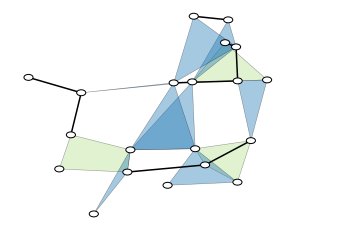

In [30]:
xgi.draw(H_viz, pos)

**Colors of the hyperedges** are designed to match the hyperedge size, but the colormap can be tweaked:

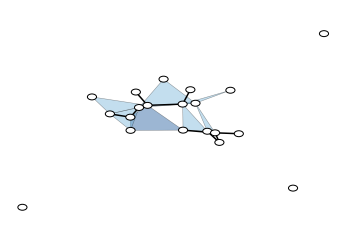

In [20]:
#Sequential colormap
cmap = cm.Blues

xgi.draw(H_viz, pos, cmap=cmap)

Other parameters can be changed as well:

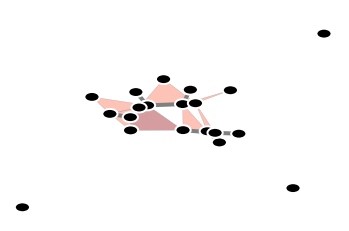

In [21]:
cmap = cm.Reds
edge_lc = 'gray'
edge_lw = 4
node_fc = 'black'
node_ec = 'white'
node_lw = 2
node_size = 0.05

xgi.draw(H_viz, pos, cmap=cmap, edge_lc=edge_lc, edge_lw=edge_lw,
         node_fc=node_fc, node_ec=node_ec, node_lw=node_lw, node_size=node_size)

Simplicial complexes can be visualized using the same functions for node layout and drawing.

#### Technical note
By definition, a simplicial complex object contains all sub-simplices. This would make the visualization heavy since all sub-simplices contained in a maximal simplex would overlap. The automatic solution for this, implemented by default in all the layouts, is to convert the simplicial complex into a hypergraph composed by solely by its maximal simplices.

#### Visual note
To visually distinguish simplicial complexes from hypergraphs, the ```draw``` function will also show all links contained in each maximal simplices (while omitting simplices of intermediate orders). 

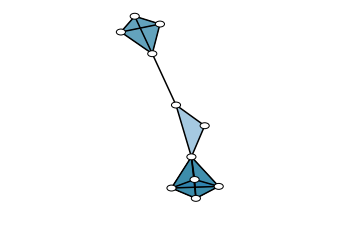

In [22]:
SC = xgi.SimplicialComplex()
SC.add_simplices_from([[3,4,5],[3,6],[6,7,8,9],[1,4,10,11,12],[1,4]])

pos = xgi.pairwise_spring_layout(SC)
xgi.draw(SC, pos)

### The stats package

The stats package is one of the features that sets `xgi` apart from other libraries.  It
provides a common interface to all statistics that can be computed from a network, its
nodes, or edges.

Consider the degree of the nodes of a hypergraph `H`.  After computing the values of the
degrees, one may wish to store them in a dict, a list, an array, a dataframe, etc.
Through the stats package, `xgi` provides a simple interface that seamlessly allows for
this type conversion.  This is done via the `NodeStat` class.

In [11]:
import xgi
H = xgi.Hypergraph([[1, 2, 3], [2, 3, 4, 5], [3, 4, 5]])
H.nodes.degree

NodeStat('degree')

This `NodeStat` object allows us to choose the datatype, specify keywords, and get basic statistics from these properties

In [12]:
print("As a dictionary:")
print(H.nodes.degree.asdict())
print("\nAs a list:")
print(H.nodes.degree.aslist())
print("\nAs a numpy array:")
print(H.nodes.degree.asnumpy())
print("\nAs a pandas dataframe:")
print(H.nodes.degree.aspandas())

As a dictionary:
{1: 1, 2: 2, 3: 3, 4: 2, 5: 2}

As a list:
[1, 2, 3, 2, 2]

As a numpy array:
[1 2 3 2 2]

As a pandas dataframe:
1    1
2    2
3    3
4    2
5    2
Name: degree, dtype: int64


In [13]:
print(H.nodes.degree(order=2).asdict())

{1: 1, 2: 1, 3: 2, 4: 1, 5: 1}


In [14]:
st = H.nodes.degree
np.round([st.max(), st.min(), st.mean(), st.median(), st.var(), st.std()], 3)

array([3.   , 1.   , 2.   , 2.   , 0.4  , 0.632])

Likewise, for edges,

In [15]:
st = H.edges.size
np.round([st.max(), st.min(), st.mean(), st.median(), st.var(), st.std()], 3)

array([4.   , 3.   , 3.333, 3.   , 0.222, 0.471])

The interface for attributes is very similar. If we add nodal attributes, for example

In [16]:
H.add_nodes_from([
        (1, {"color": "red", "name": "horse"}),
        (2, {"color": "blue", "name": "pony"}),
        (3, {"color": "yellow", "name": "zebra"}),
        (4, {"color": "red", "name": "orangutan", "age": 20}),
        (5, {"color": "blue", "name": "fish", "age": 2}),
    ])
print(H.nodes.attrs("color").aslist())
print(H.nodes.attrs[1])

['red', 'blue', 'yellow', 'red', 'blue']
{'color': 'red', 'name': 'horse'}


One can also filter nodes and edges by their attributes as well as any associated statistic. For example,

In [17]:
print(H.nodes.filterby("degree", 2))
print(H.nodes.filterby_attr("color", "blue"))
print(H.edges.filterby("size", 3).members())

[2, 4, 5]
[2, 5]
[[1, 2, 3], [3, 4, 5]]


## An example

Let's compare the assortativity of an empirical dataset (Let's choose the `email-enron` dataset) to a random null model. We start by loading the Enron dataset and constructing a Chung-Lu hypergraph using the dataset's degree sequence and edge size sequence:

In [23]:
H = xgi.load_xgi_data("email-enron")
k = H.nodes.degree.asdict()
s = H.edges.size.asdict()

H_null = xgi.chung_lu_hypergraph(k, s)

Now we use the definitions of assortativity in "Configuration models of random hypergraphs" by Phil Chodrow to compare the assortativity of the random null model to the original dataset.

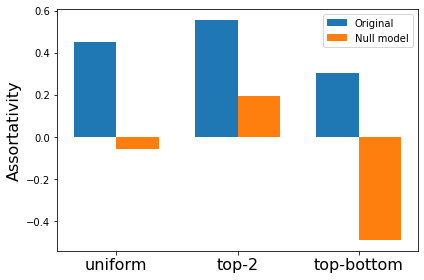

In [24]:
labels = ['uniform', 'top-2', 'top-bottom']

assort_orig = list()
assort_null = list()
for l in labels:
    assort_orig.append(xgi.degree_assortativity(H, kind=l))
    assort_null.append(xgi.degree_assortativity(H_null, kind=l))

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, assort_orig, width, label='Original')
rects2 = ax.bar(x + width/2, assort_null, width, label='Null model')
ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize=16)
ax.set_ylabel("Assortativity", fontsize=16)
ax.legend()
plt.tight_layout()
plt.show()